In [1]:
## follow the tutorial on https://github.com/boxiangliu/enformer

import tensorflow as tf
import tensorflow_hub as hub
import joblib
import gzip
import kipoiseq
from kipoiseq import Interval
import pyfaidx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

2023-02-15 10:26:33.348480: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-15 10:26:35.571226: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/slurm/slurm-20.11.0/lib64:/opt/slurm/slurm-20.11.0/lib64:/opt/slurm/slurm-20.11.0/lib64:
2023-02-15 10:26:35.571379: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-15 10:26:49.494743: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dyna

In [45]:
transform_path = 'gs://dm-enformer/models/enformer.finetuned.SAD.robustscaler-PCA500-robustscaler.transform.pkl'
model_path = 'https://tfhub.dev/deepmind/enformer/1'
fasta_file = '/gpfs/commons/home/tlin/data/enformer/hg38.fa'
clinvar_vcf = '/gpfs/commons/home/tlin/data/enformer/clinvar.vcf.gz'

In [3]:
# Download targets from Basenji2 dataset 
# Cite: Kelley et al Cross-species regulatory sequence activity prediction. PLoS Comput. Biol. 16, e1008050 (2020).
targets_txt = 'https://raw.githubusercontent.com/calico/basenji/master/manuscripts/cross2020/targets_human.txt'
df_targets = pd.read_csv(targets_txt, sep='\t')
df_targets.head(3)

,index,genome,identifier,file,clip,scale,sum_stat,description
0,0,0,ENCFF833POA,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:cerebellum male adult (27 years) and mal...
1,1,0,ENCFF110QGM,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:frontal cortex male adult (27 years) and...
2,2,0,ENCFF880MKD,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:chorion


In [4]:
pyfaidx.Faidx(fasta_file)

Faidx("/gpfs/commons/home/tlin/data/enformer/hg38.fa")

In [5]:
# @title `Enformer`, `EnformerScoreVariantsNormalized`, `EnformerScoreVariantsPCANormalized`,
SEQUENCE_LENGTH = 393216

class Enformer:

  def __init__(self, tfhub_url):
    self._model = hub.load(tfhub_url).model

  def predict_on_batch(self, inputs):
    predictions = self._model.predict_on_batch(inputs)
    return {k: v.numpy() for k, v in predictions.items()}

  @tf.function
  def contribution_input_grad(self, input_sequence,
                              target_mask, output_head='human'):
    input_sequence = input_sequence[tf.newaxis]

    target_mask_mass = tf.reduce_sum(target_mask)
    with tf.GradientTape() as tape:
      tape.watch(input_sequence)
      prediction = tf.reduce_sum(
          target_mask[tf.newaxis] *
          self._model.predict_on_batch(input_sequence)[output_head]) / target_mask_mass

    input_grad = tape.gradient(prediction, input_sequence) * input_sequence
    input_grad = tf.squeeze(input_grad, axis=0)
    return tf.reduce_sum(input_grad, axis=-1)


class EnformerScoreVariantsRaw:

  def __init__(self, tfhub_url, organism='human'):
    self._model = Enformer(tfhub_url)
    self._organism = organism
  
  def predict_on_batch(self, inputs):
    ref_prediction = self._model.predict_on_batch(inputs['ref'])[self._organism]
    alt_prediction = self._model.predict_on_batch(inputs['alt'])[self._organism]

    return alt_prediction.mean(axis=1) - ref_prediction.mean(axis=1)


class EnformerScoreVariantsNormalized:

  def __init__(self, tfhub_url, transform_pkl_path,
               organism='human'):
    assert organism == 'human', 'Transforms only compatible with organism=human'
    self._model = EnformerScoreVariantsRaw(tfhub_url, organism)
    with tf.io.gfile.GFile(transform_pkl_path, 'rb') as f:
      transform_pipeline = joblib.load(f)
    self._transform = transform_pipeline.steps[0][1]  # StandardScaler.
    
  def predict_on_batch(self, inputs):
    scores = self._model.predict_on_batch(inputs)
    return self._transform.transform(scores)


class EnformerScoreVariantsPCANormalized:

  def __init__(self, tfhub_url, transform_pkl_path,
               organism='human', num_top_features=500):
    self._model = EnformerScoreVariantsRaw(tfhub_url, organism)
    with tf.io.gfile.GFile(transform_pkl_path, 'rb') as f:
      self._transform = joblib.load(f)
    self._num_top_features = num_top_features
    
  def predict_on_batch(self, inputs):
    scores = self._model.predict_on_batch(inputs)
    return self._transform.transform(scores)[:, :self._num_top_features]


# TODO(avsec): Add feature description: Either PCX, or full names.

In [6]:
# @title `variant_centered_sequences`

class FastaStringExtractor:
    
    def __init__(self, fasta_file):
        self.fasta = pyfaidx.Fasta(fasta_file)
        self._chromosome_sizes = {k: len(v) for k, v in self.fasta.items()}

    def extract(self, interval: Interval, **kwargs) -> str:
        # Truncate interval if it extends beyond the chromosome lengths.
        chromosome_length = self._chromosome_sizes[interval.chrom]
        trimmed_interval = Interval(interval.chrom,
                                    max(interval.start, 0),
                                    min(interval.end, chromosome_length),
                                    )
        # pyfaidx wants a 1-based interval
        sequence = str(self.fasta.get_seq(trimmed_interval.chrom,
                                          trimmed_interval.start + 1,
                                          trimmed_interval.stop).seq).upper()
        # Fill truncated values with N's.
        pad_upstream = 'N' * max(-interval.start, 0)
        pad_downstream = 'N' * max(interval.end - chromosome_length, 0)
        return pad_upstream + sequence + pad_downstream

    def close(self):
        return self.fasta.close()


def variant_generator(vcf_file, gzipped=False):
  """Yields a kipoiseq.dataclasses.Variant for each row in VCF file."""
  def _open(file):
    return gzip.open(vcf_file, 'rt') if gzipped else open(vcf_file)
    
  with _open(vcf_file) as f:
    for line in f:
      if line.startswith('#'):
        continue
      chrom, pos, id, ref, alt_list = line.split('\t')[:5]
      # Split ALT alleles and return individual variants as output.
      for alt in alt_list.split(','):
        yield kipoiseq.dataclasses.Variant(chrom=chrom, pos=pos,
                                           ref=ref, alt=alt, id=id)


def one_hot_encode(sequence):
  return kipoiseq.transforms.functional.one_hot_dna(sequence).astype(np.float32)


def variant_centered_sequences(vcf_file, sequence_length, gzipped=False,
                               chr_prefix=''):
  seq_extractor = kipoiseq.extractors.VariantSeqExtractor(
    reference_sequence=FastaStringExtractor(fasta_file))

  for variant in variant_generator(vcf_file, gzipped=gzipped):
    interval = Interval(chr_prefix + variant.chrom,
                        variant.pos, variant.pos)
    interval = interval.resize(sequence_length)
    center = interval.center() - interval.start

    reference = seq_extractor.extract(interval, [], anchor=center)
    alternate = seq_extractor.extract(interval, [variant], anchor=center)

    yield {'inputs': {'ref': one_hot_encode(reference),
                      'alt': one_hot_encode(alternate)},
           'metadata': {'chrom': chr_prefix + variant.chrom,
                        'pos': variant.pos,
                        'id': variant.id,
                        'ref': variant.ref,
                        'alt': variant.alt}}

In [7]:
def plot_tracks(tracks, interval, height=1.5):
  fig, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True)
  for ax, (title, y) in zip(axes, tracks.items()):
    ax.fill_between(np.linspace(interval.start, interval.end, num=len(y)), y)
    ax.set_title(title)
    sns.despine(top=True, right=True, bottom=True)
  ax.set_xlabel(str(interval))
  plt.tight_layout()

## Make predictions for a genetic sequence

In [10]:
model = Enformer(model_path)
fasta_extractor = FastaStringExtractor("/gpfs/commons/home/tlin/data/enformer/hg38.fa")
fasta_file = "/gpfs/commons/home/tlin/data/enformer/hg38.fa"

2023-02-15 10:28:01.566723: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/slurm/slurm-20.11.0/lib64:/opt/slurm/slurm-20.11.0/lib64:/opt/slurm/slurm-20.11.0/lib64:
2023-02-15 10:28:01.566796: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-15 10:28:01.566828: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pe2dc5-013.c.nygenome.org): /proc/driver/nvidia/version does not exist
2023-02-15 10:28:01.586666: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operat

In [32]:
# @title Make predictions for an genomic example interval
## use a gene as example 
## BIN1 chr2:127,048,027-127,107,288
target_interval = kipoiseq.Interval('chr2', 127_048_027, 127_107_288)  # @param
sequence_one_hot = one_hot_encode(fasta_extractor.extract(target_interval.resize(SEQUENCE_LENGTH)))
predictions = model.predict_on_batch(sequence_one_hot[np.newaxis])['human'][0]

In [22]:
pd.set_option('display.max_colwidth', -1)
df_targets.iloc[5110].description

/gpfs/commons/home/tlin/miniconda3/envs/enformer/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


'CAGE:B lymphoblastoid cell line: GM12878 ENCODE, biol_'

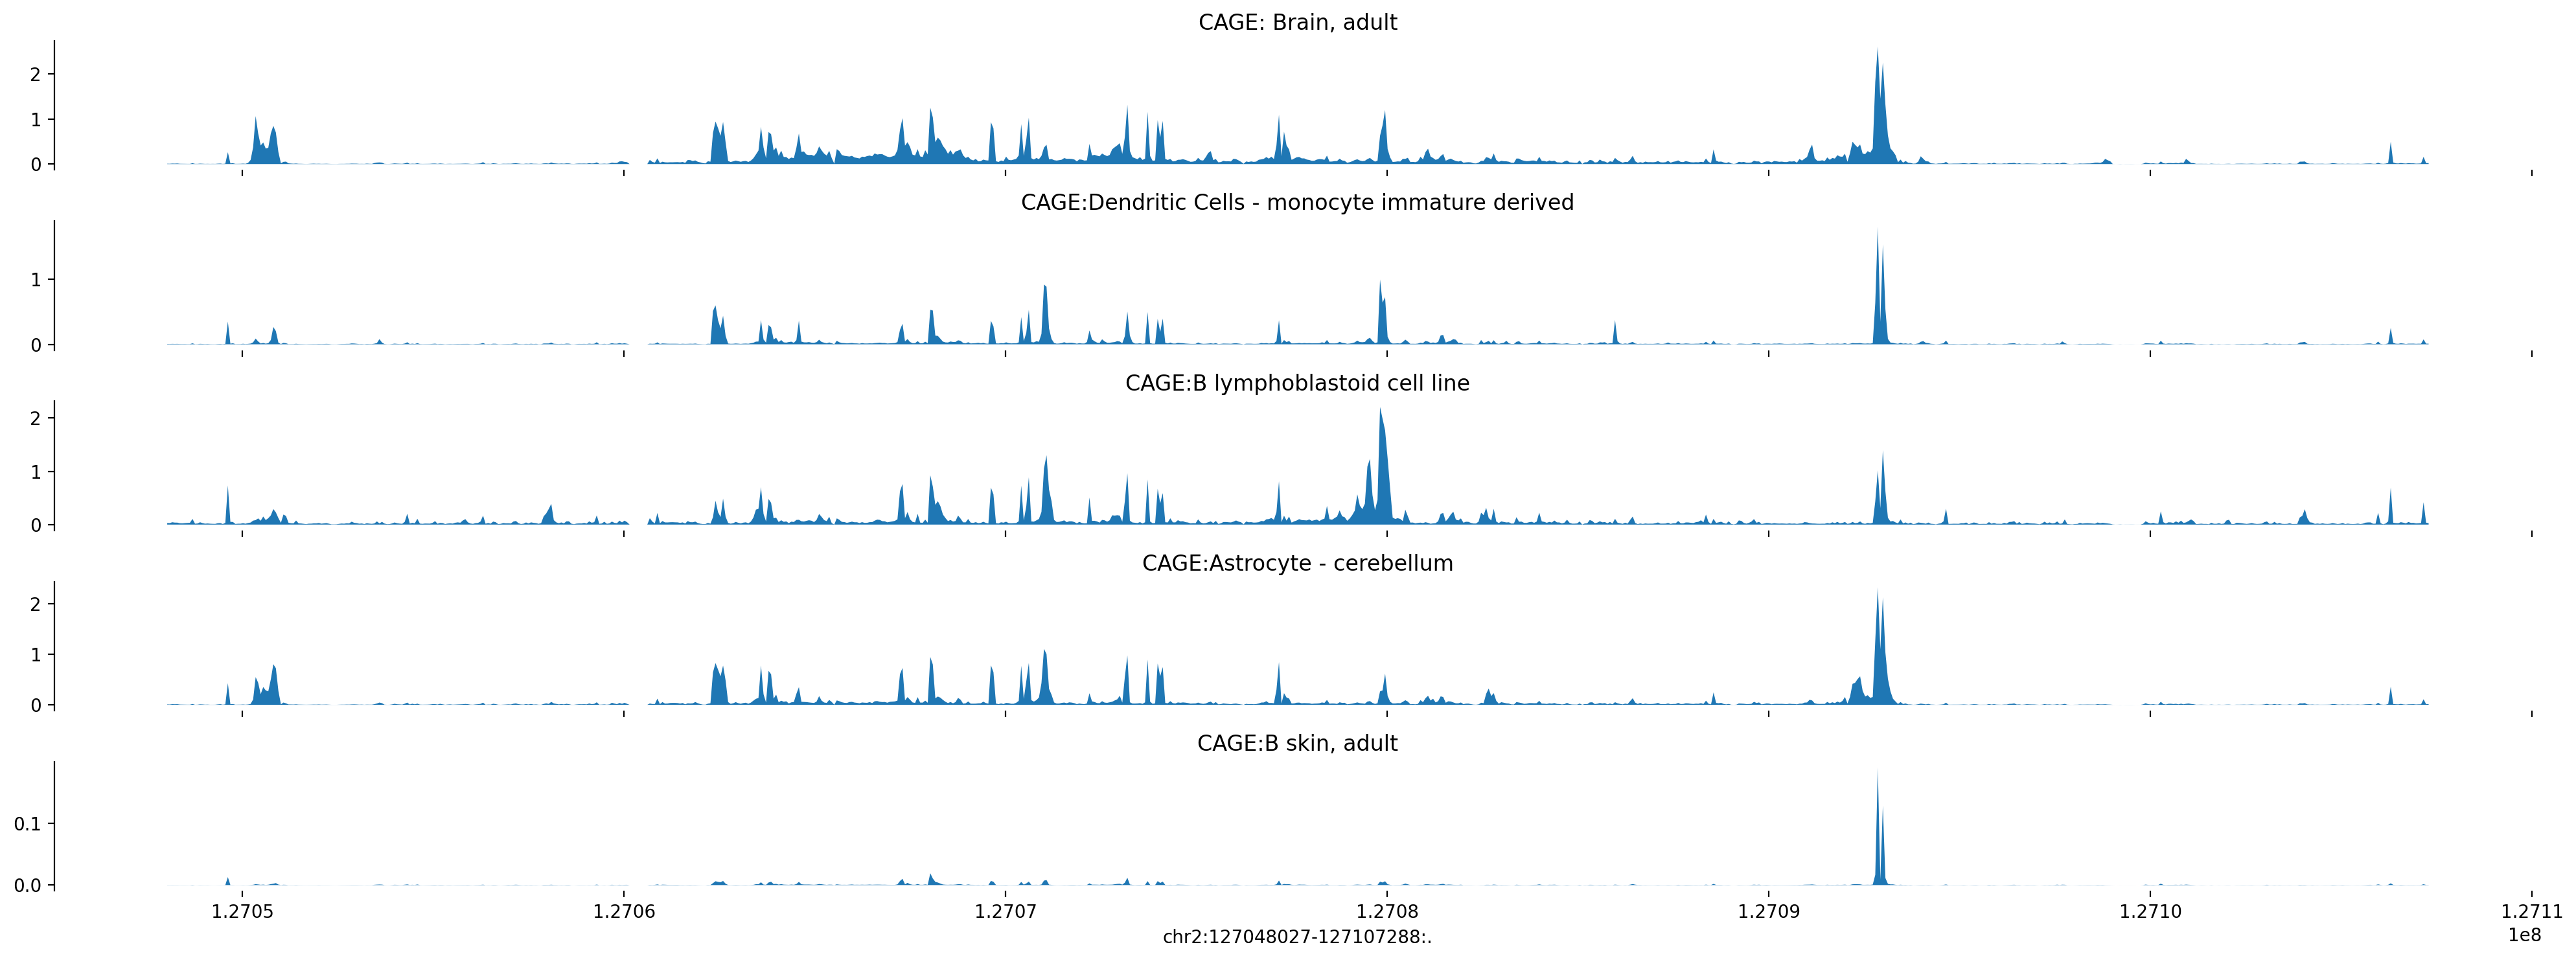

In [33]:
# @title Plot tracks
## compare ad-related and ad-nonrelated cell
tracks = {'CAGE: Brain, adult':  np.log10(1 + predictions[:, 4680]),
          'CAGE:Dendritic Cells - monocyte immature derived': np.log10(1 + predictions[:, 4761]),
          'CAGE:B lymphoblastoid cell line': np.log10(1 + predictions[:, 5110]),
          'CAGE:Astrocyte - cerebellum': np.log10(1 + predictions[:, 4873]),
          'CAGE:skin, adult': np.log10(1 + predictions[:, 4970])}
plot_tracks(tracks, target_interval)

In [ ]:
## Variant scoring

In [36]:
# @title Score the variant

variant = kipoiseq.Variant('chr2', 127077657, 'C', 'T', id='rs4663105')  # @param

# Center the interval at the variant
interval = kipoiseq.Interval(variant.chrom, variant.start, variant.start).resize(SEQUENCE_LENGTH)
seq_extractor = kipoiseq.extractors.VariantSeqExtractor(reference_sequence=fasta_extractor)
center = interval.center() - interval.start

reference = seq_extractor.extract(interval, [], anchor=center)
alternate = seq_extractor.extract(interval, [variant], anchor=center)

# Make predictions for the refernece and alternate allele
reference_prediction = model.predict_on_batch(one_hot_encode(reference)[np.newaxis])['human'][0]
alternate_prediction = model.predict_on_batch(one_hot_encode(alternate)[np.newaxis])['human'][0]

In [34]:
(127048027+127107288)/2


127077657.5

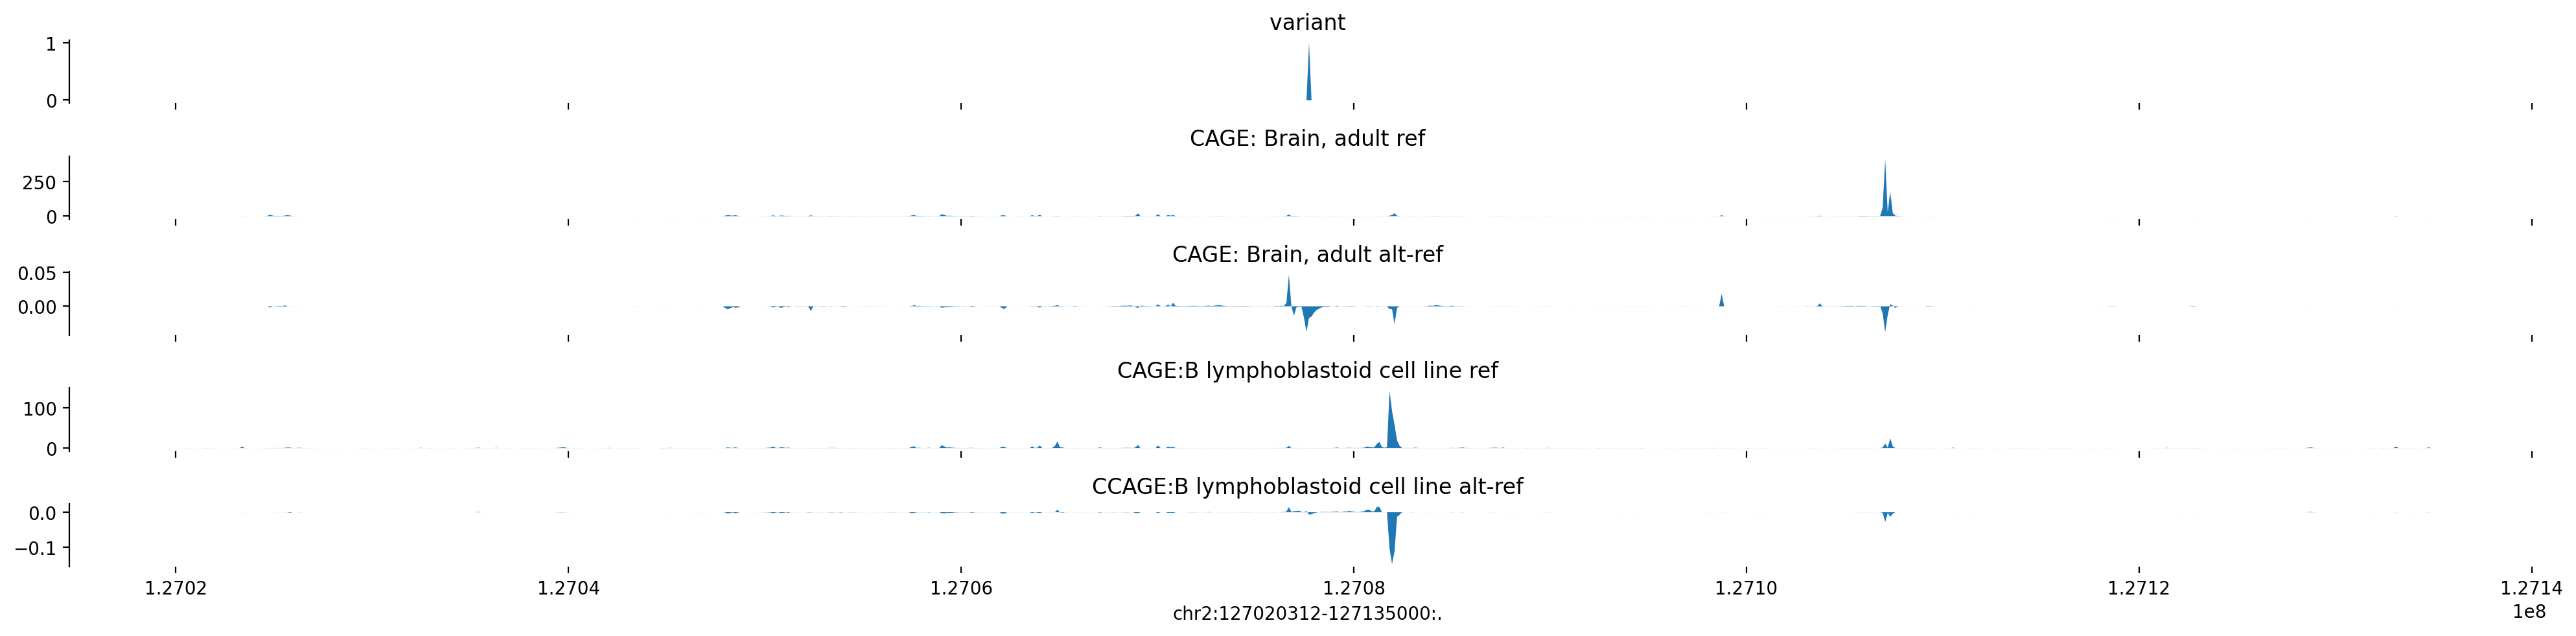

In [37]:
# @title Visualize some tracks
variant_track = np.zeros_like(reference_prediction[:, 0], dtype=bool)
variant_track[variant_track.shape[0] // 2] = True
tracks = {'variant': variant_track,
          'CAGE: Brain, adult ref': reference_prediction[:, 4680],
          'CAGE: Brain, adult alt-ref': alternate_prediction[:, 4680] - reference_prediction[:, 4680],
          'CAGE:B lymphoblastoid cell line ref': reference_prediction[:, 5110],
          'CCAGE:B lymphoblastoid cell line alt-ref': alternate_prediction[:, 5110] - reference_prediction[:, 5110],
          }

plot_tracks(tracks, interval.resize(reference_prediction.shape[0] * 128), height=1)

## score variants in VCF 

In [47]:
## report top 20 pcs
enformer_score_variants = EnformerScoreVariantsPCANormalized(model_path, transform_path, num_top_features=20)

ValueError: Parameter config in `Enformer(config)` should be an instance of class `PretrainedConfig`. To create a model from a pretrained model use `model = Enformer.from_pretrained(PRETRAINED_MODEL_NAME)`

In [35]:
# Score the first 5 variants from ClinVar
# Lower-dimensional scores (20 PCs)
it = variant_centered_sequences(clinvar_vcf, sequence_length=SEQUENCE_LENGTH,
                                gzipped=True, chr_prefix='chr')
example_list = []
for i, example in enumerate(it):
  if i >= 5:
    break
  variant_scores = enformer_score_variants.predict_on_batch(
      {k: v[tf.newaxis] for k,v in example['inputs'].items()})[0]
  variant_scores = {f'PC{i}': score for i, score in enumerate(variant_scores)}
  example_list.append({**example['metadata'],
                       **variant_scores})
  if i % 2 == 0:
    print(f'Done {i}')
df = pd.DataFrame(example_list)
df

NameError: name 'enformer_score_variants' is not defined

In [48]:
enformer_score_variants_all = EnformerScoreVariantsNormalized(model_path, transform_path)

ValueError: Parameter config in `Enformer(config)` should be an instance of class `PretrainedConfig`. To create a model from a pretrained model use `model = Enformer.from_pretrained(PRETRAINED_MODEL_NAME)`

In [48]:
it

<generator object variant_centered_sequences at 0x7fbbc6dcaa50>

In [49]:
for i , example in enumerate(it):
    print(example)
    break

{'inputs': {'ref': array([[0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       ...,
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ]], dtype=float32), 'alt': array([[0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       ...,
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ]], dtype=float32)}, 'metadata': {'chrom': 'chr1', 'pos': 69134, 'id': '2205837', 'ref': 'A', 'alt': 'G'}}


In [40]:

import torch
from enformer_pytorch import Enformer, seq_indices_to_one_hot
#!pip install enformer-pytorch>=0.5


In [41]:
enformer = Enformer.from_pretrained('EleutherAI/enformer-official-rough')

In [42]:
#from enformer_pytorch import Enformer

model = Enformer.from_pretrained('EleutherAI/enformer-official-rough', target_length = 128, dropout_rate = 0.1)

# do your fine-tuning

In [52]:
import torch
import polars as pl
from enformer_pytorch import Enformer, GenomeIntervalDataset
filter_train = lambda df: df.filter(pl.col('column_4') == 'train')

ds = GenomeIntervalDataset(
    bed_file = './sequences.bed',                       # bed file - columns 0, 1, 2 must be <chromosome>, <start position>, <end position>
    fasta_file = './hg38.ml.fa',                        # path to fasta file
    filter_df_fn = filter_train,                        # filter dataframe function
    return_seq_indices = True,                          # return nucleotide indices (ACGTN) or one hot encodings
    shift_augs = (-2, 2),                               # random shift augmentations from -2 to +2 basepairs
    context_length = 196_608,
    # this can be longer than the interval designated in the .bed file,
    # in which case it will take care of lengthening the interval on either sides
    # as well as proper padding if at the end of the chromosomes
    chr_bed_to_fasta_map = {
        'chr1': 'chromosome1',  # if the chromosome name in the .bed file is different than the key name in the fasta file, you can rename them on the fly
        'chr2': 'chromosome2',
        'chr3': 'chromosome3',
        # etc etc
    }
)

model = Enformer.from_hparams(
    dim = 1536,
    depth = 11,
    heads = 8,
    output_heads = dict(human = 5313, mouse = 1643),
    target_length = 896,
)

seq = ds[0] # (196608,)
pred = model(seq, head = 'human') # (896, 5313)
filter_train = lambda df: df.filter(pl.col('column_4') == 'train')

ds = GenomeIntervalDataset(
    bed_file = './sequences.bed',                       # bed file - columns 0, 1, 2 must be <chromosome>, <start position>, <end position>
    fasta_file = './hg38.ml.fa',                        # path to fasta file
    filter_df_fn = filter_train,                        # filter dataframe function
    return_seq_indices = True,                          # return nucleotide indices (ACGTN) or one hot encodings
    shift_augs = (-2, 2),                               # random shift augmentations from -2 to +2 basepairs
    rc_aug = True,                                      # use reverse complement augmentation with 50% probability
    context_length = 196_608,
    return_augs = True                                  # return the augmentation meta data
)

seq, rand_shift_val, rc_bool = ds[0] # (196608,), (1,), (1,)

AssertionError: path to .bed file must exist